In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Creating DataFrame

# Change to your current directory
path = '/home/ilkin/Repos/datasci/london/'

def multiple_csv_to_df(path, app):
    path += app + '*.csv'
    files = glob.glob(path)
    files.sort()
    dfdict = {}
    for idx, f in enumerate(files):
        dfdict[f'df{idx}'] = pd.read_csv(f, index_col=0)
    return dfdict

dfdict = multiple_csv_to_df(path, 'postcodes/')
df = pd.DataFrame()
for d in dfdict.values():
    df = pd.concat([df, d])

lookups_df = pd.read_csv(path + 'postcodes/lookup/ukpostcodes.csv', index_col=1)

# Drop unused data
lookups_df.drop(columns=['id'], inplace=True)
df.drop(columns=['Males', 'Females', 'Occupied_Households'], inplace=True)
 
# Standardise postcode format
lookups_df.index = lookups_df.index.str.replace(' ', '')
df.index = df.index.str.replace(' ', '')

# Look up each postcode's lat/lon values and append to row
df = df.join(lookups_df)
df

,Total,latitude,longitude
Postcode,,,
AL11AG,14,51.745290,-0.328628
AL11AJ,124,51.744498,-0.328599
AL11AR,32,51.739727,-0.317484
AL11AS,34,51.749073,-0.335471
AL11BH,52,51.746852,-0.338000
...,...,...,...
YO89YA,23,53.770419,-1.158828
YO89YB,33,53.770000,-1.159352
YO89YD,9,53.769733,-1.171313


In [9]:
# Crop data to a city

def crop_to_city(df, lat_bounds=(51.2, 51.8), lon_lower_bound=-0.4):
    lat_range = lat_bounds[1] - lat_bounds[0]
    nf = df.copy() # new dataframe
    nf = nf[np.logical_and(nf['latitude']>51.2, nf['latitude']<51.8)]
    nf = nf[np.logical_and(nf['longitude']>-0.4, nf['longitude']<(lon_lower_bound + lat_range))]
    return nf

# Uncomment for Birmingham
# nf = crop_to_city(lat_bounds=(52.36, 52.66), lon_lower_bound=-2.29)

# Defaults are for London
nf = crop_to_city(df) # new dataframe

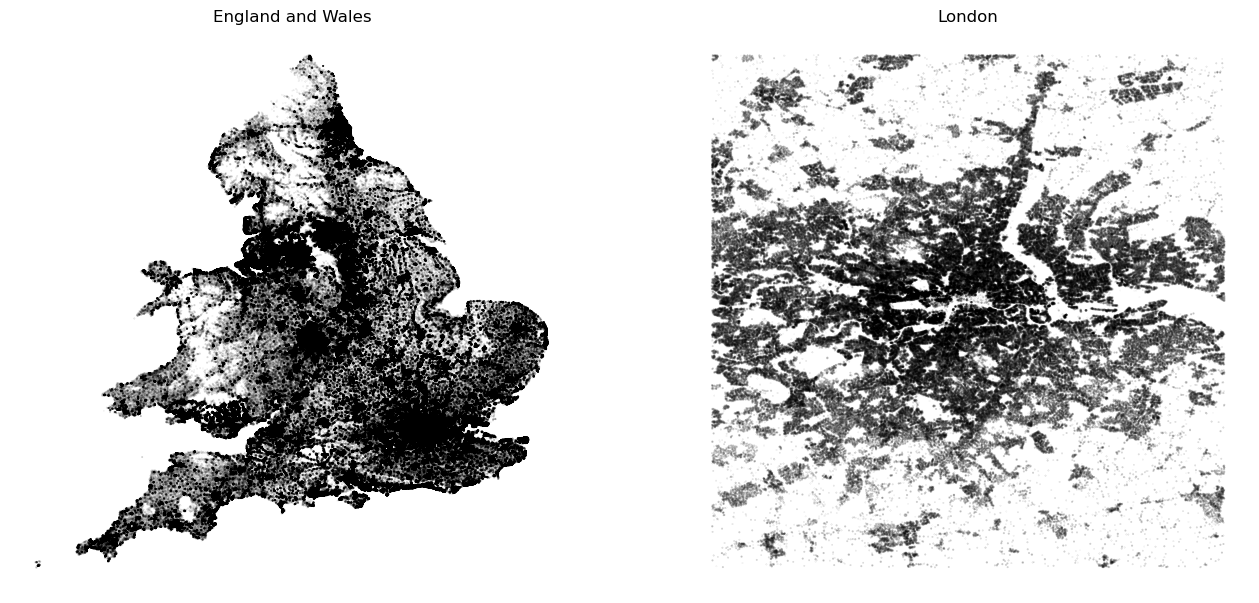

In [12]:
# Preliminary plots for visualisation

def scatter_plot(df, ax):
    ax.scatter(df['longitude'], df['latitude'], s=df['Total'] / 150, alpha=0.2, c='k')
    ax.set_box_aspect(1)
    ax.axis('off')
    return ax

fig, ax = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(16)

titles = ['England and Wales', 'London']
dataframes = [df, nf]
for i in range(2):
    ax[i] = scatter_plot(dataframes[i], ax[i])
    ax[i].set_title(titles[i])
plt.show()


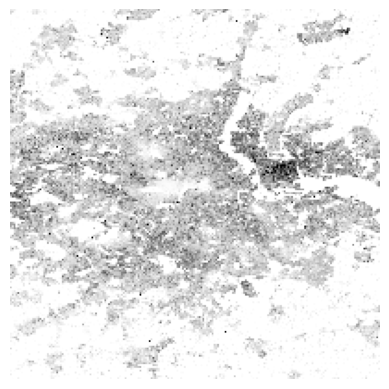

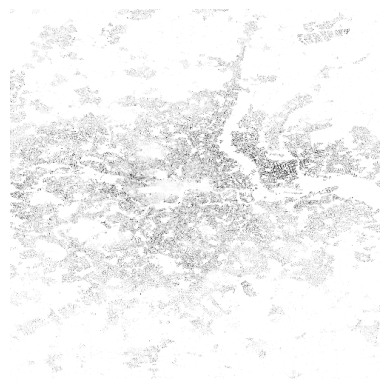

In [7]:
# Create matrices for analysis

def create_2d_histogram(df, matsize, lat_bounds=(51.2, 51.8), lon_lower_bound=-0.4):
    hist_mat = np.zeros((matsize, matsize))
    tf = pd.DataFrame() # temporary dataframe
    lat_range = lat_bounds[1] - lat_bounds[0]
    increment = lat_range / matsize
    lat_lower_bound = lat_bounds[0]
    for i in range(matsize):
        for j in range(matsize):

            # tf becomes dataframe of all points falling in a bin
            tf = df[np.logical_and(df['latitude']>(lat_lower_bound + increment*i), df['latitude']<(lat_lower_bound + increment*(i+1)))]
            tf = tf[np.logical_and(tf['longitude']>(lon_lower_bound + increment*j), tf['longitude']<(lon_lower_bound + increment*(j+1)))]

            # Value of each bin becomes weighted average of tf's `Total` column
            series = tf['Total']
            value = series.sum() / (len(series) + 1)

            # If value is above 140, it becomes 140 (arbitrary cutoff)
            valid = value < 140
            hist_mat[-i-1, j] = valid * value + abs(valid - 1) * 150
    return hist_mat

def plot_save_matrix(res):
    hist_mat = create_2d_histogram(nf, res, (51.2, 51.8), -0.4)
    np.save(f'../np/large_res{res}x{res}', hist_mat)
    plt.imshow(hist_mat, cmap='Greys')
    plt.axis('off')
    plt.show()

plot_save_matrix(200)
plot_save_matrix(500)